https://www.kaggle.com/code/ahmedashrafhelmi/ecg-classification-rnn-gru-lstm

## Import libraries

In [ ]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os

In [2]:
# Set seed
SEED = 11
torch.manual_seed(SEED)

## PyTorch version and device check

In [3]:
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")

PyTorch version: 2.5.1+cu124
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce GTX 1660 SUPER


## Get csv files

In [4]:
dataframes = {}
# directory_path = 'Arrhythmia_Dataset'
directory_path = 'Heartbeat_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path)


In [5]:
print(dataframes.keys())

dict_keys(['mitbih_test', 'mitbih_train', 'ptbdb_abnormal', 'ptbdb_normal'])


## Exploratory Data Analysis

In [6]:
# df = dataframes['MIT-BIH Arrhythmia Database']

# Retrieve train and test datasets
train_df = dataframes['mitbih_train']
test_df = dataframes['mitbih_test']

In [7]:
# Preview of train dataset
train_df.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Check number of samples in datasets
print(f"Number of samples in train data: {train_df.shape[0]}, test data: {test_df.shape[0]}\n")

# Check distribution of classes in test and train sets
print("Train dataset class distribution")
print(train_df.iloc[:, -1].value_counts())
print("\nTest dataset class distribution")
print(test_df.iloc[:, -1].value_counts())

Number of samples in train data: 87553, test data: 21891

Train dataset class distribution
0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Test dataset class distribution
0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [9]:
# Labels for numbered categories
labels = {
    0: "N",
    1: "S",
    2: "V",
    3: "F",
    4: "Q"
}

C:\Users\User\AppData\Local\Temp\ipykernel_4272\646828076.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{train_counts[i]}',


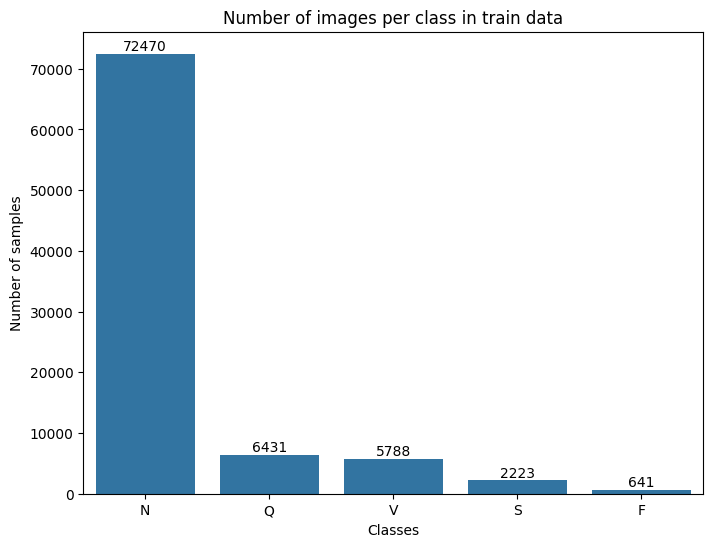

In [10]:
train_counts = train_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=train_counts.index, y=train_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_4272\578734644.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{test_counts[i]}',


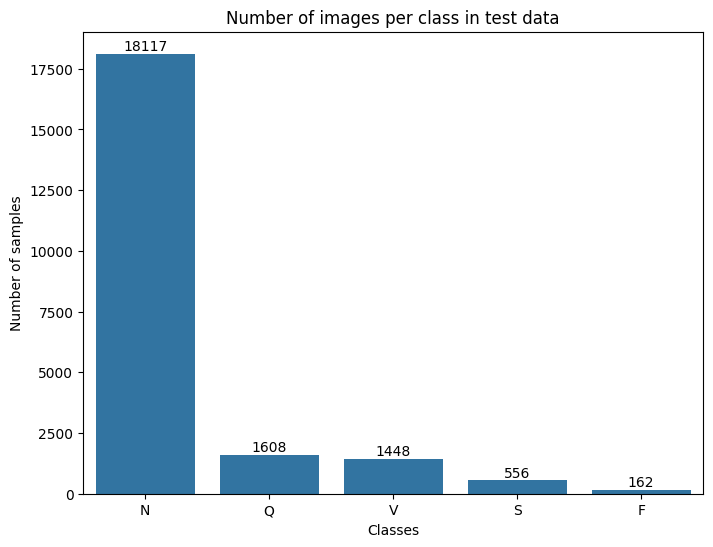

In [11]:
test_counts = test_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=test_counts.index, y=test_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

## Preprocess dataset

In [12]:
# Separate features and labels
X_train = train_df.iloc[:, :-1].values  # Exclude label
y_train = train_df.iloc[:, -1].values   # Labels

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Scaling the dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split the training data to obtain new train and validation sets
# Stratifying the split so both train and validation sets have same class distribution
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

print(f"New Training set: {X_train_new.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_scaled.shape}")

New Training set: (70042, 187)
Validation set: (17511, 187)
Test set: (21891, 187)


In [13]:
# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features), one feature per timestep
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train_new = np.reshape(X_train_new, (X_train_new.shape[0], X_train_new.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled, (X_test.shape[0], X_test.shape[1], 1))

print(f"New Training set size: {X_train_new.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test_scaled.shape}")

New Training set size: (70042, 187, 1)
Validation set size: (17511, 187, 1)
Test set size: (21891, 187, 1)


## RNN Model

In [14]:
class RNNModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size = inputSize,
            hidden_size = hiddenSize,
            num_layers = numLayers,
            batch_first = True
        )

        self.fc = nn.Linear(hiddenSize, numClasses)
        return

    def forward(self, x):
        # Forward pass through RNN layers
        out, _ = self.rnn(x)

        # Use output from last timestep
        out = out[:, -1, :]

        # Pass output to fully connected layer
        out = self.fc(out)

        return out

In [15]:
# Variables
inputSize = 1
hiddenSize = 64
numClasses = 5
numLayers = 1
learningRate = 0.001
numEpochs = 20

In [16]:
# Instantiate model
rnn_model = RNNModel(inputSize, hiddenSize, numLayers, numClasses)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learningRate)

# Loss function
criterion = nn.CrossEntropyLoss()

In [17]:
# Prepare datasets in batches
from torch.utils.data import DataLoader, TensorDataset

# Define batch size
batchSize = 32

# Create DataLoader for training and validation sets
def get_dataloaders(X_train, X_test, y_train, y_test):
    train_dataset = TensorDataset(torch.as_tensor(X_train, dtype=torch.float), torch.as_tensor(y_train, dtype=torch.float))
    val_dataset = TensorDataset(torch.as_tensor(X_test, dtype=torch.float), torch.as_tensor(y_test, dtype=torch.float))

    train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=batchSize)

    return train_loader, test_loader

In [18]:
def train_val(model, optimizer, train_loader, test_loader):

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(numEpochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        train_correct = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
            # X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
            
            # Forward pass
            outputs = model(X_batch)
            # print(f'Output {outputs.shape}, y_batch {y_batch.shape}')
            loss = criterion(outputs, y_batch.long())
            
            # Backward pass and optimization
            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == y_batch).sum().item()
            
            train_loss += loss.item() * X_batch.size(0)  # Accumulate loss
        
        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation/Testing
        model.eval()  # Set the model to evaluation mode
        test_loss = 0
        correct = 0
        
        with torch.no_grad():  # No need to calculate gradients for validation
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # print(f"X_batch {X_batch.shape}")
                # X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.long())
                test_loss += loss.item() * X_batch.size(0)
                
                # Get predictions
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
        
        # Calculate average validation loss and accuracy
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Print epoch results
        print(f'Epoch [{epoch + 1}/{numEpochs}], '
            f'Train Loss: {train_loss:.4f}, '
            f'Train Accuracy: {train_accuracy * 100:.2f}%, '
            f'Test Loss: {test_loss:.4f}, '
            f'Test Accuracy: {test_accuracy * 100:.2f}%')
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [19]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(rnn_model, rnn_optimizer, train_loader, val_loader)

Epoch [1/20], Train Loss: 0.6635, Train Accuracy: 82.60%, Test Loss: 0.6586, Test Accuracy: 82.76%
Epoch [2/20], Train Loss: 0.6523, Train Accuracy: 82.82%, Test Loss: 0.6535, Test Accuracy: 82.79%
Epoch [3/20], Train Loss: 0.6499, Train Accuracy: 82.79%, Test Loss: 0.6505, Test Accuracy: 82.70%
Epoch [4/20], Train Loss: 0.6527, Train Accuracy: 82.77%, Test Loss: 0.6643, Test Accuracy: 82.77%
Epoch [5/20], Train Loss: 0.6446, Train Accuracy: 82.78%, Test Loss: 0.7075, Test Accuracy: 82.79%
Epoch [6/20], Train Loss: 0.6327, Train Accuracy: 82.88%, Test Loss: 0.6256, Test Accuracy: 82.85%
Epoch [7/20], Train Loss: 0.6279, Train Accuracy: 82.83%, Test Loss: 0.6274, Test Accuracy: 82.86%
Epoch [8/20], Train Loss: 0.6285, Train Accuracy: 82.86%, Test Loss: 0.6281, Test Accuracy: 82.90%
Epoch [9/20], Train Loss: 0.6278, Train Accuracy: 82.94%, Test Loss: 0.6287, Test Accuracy: 82.92%
Epoch [10/20], Train Loss: 0.6306, Train Accuracy: 82.86%, Test Loss: 0.6266, Test Accuracy: 82.79%
Epoch [11

In [20]:
# Save trained model
PATH = "./model/simple_rnn_model.pth"
torch.save(rnn_model.state_dict(), PATH)

In [21]:
# Load model   
PATH = "./model/simple_rnn_model.pth"
rnn_model = RNNModel(inputSize, hiddenSize, numLayers, numClasses)
rnn_model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

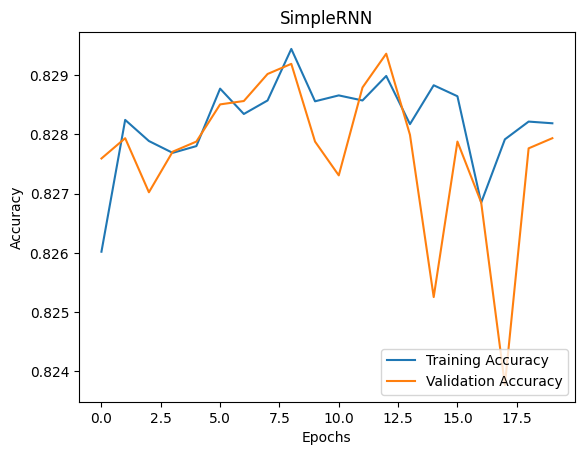

In [22]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleRNN')
plt.legend(loc='lower right')
plt.show()

## Long Short Term Memory (LSTM) Model

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(LSTMModel, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = inputSize, 
                            hidden_size = hiddenSize, 
                            num_layers = numLayers, 
                            batch_first=True
                            )
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hiddenSize, numClasses)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [24]:
# Instantiate model
lstm_model = LSTMModel(inputSize, hiddenSize, numLayers, numClasses)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learningRate)

In [25]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(lstm_model, lstm_optimizer, train_loader, val_loader)

Epoch [1/20], Train Loss: 0.6633, Train Accuracy: 82.65%, Test Loss: 0.6510, Test Accuracy: 82.79%
Epoch [2/20], Train Loss: 0.6474, Train Accuracy: 82.80%, Test Loss: 0.6508, Test Accuracy: 82.71%
Epoch [3/20], Train Loss: 0.6419, Train Accuracy: 82.43%, Test Loss: 0.6484, Test Accuracy: 83.36%
Epoch [4/20], Train Loss: 0.6416, Train Accuracy: 83.35%, Test Loss: 0.6315, Test Accuracy: 83.43%
Epoch [5/20], Train Loss: 0.6295, Train Accuracy: 83.38%, Test Loss: 0.6254, Test Accuracy: 83.40%
Epoch [6/20], Train Loss: 0.6288, Train Accuracy: 83.13%, Test Loss: 0.6328, Test Accuracy: 82.68%
Epoch [7/20], Train Loss: 0.6328, Train Accuracy: 82.82%, Test Loss: 0.6185, Test Accuracy: 82.77%
Epoch [8/20], Train Loss: 0.5557, Train Accuracy: 82.74%, Test Loss: 0.5356, Test Accuracy: 82.85%
Epoch [9/20], Train Loss: 0.6111, Train Accuracy: 82.83%, Test Loss: 0.6399, Test Accuracy: 82.77%
Epoch [10/20], Train Loss: 0.6204, Train Accuracy: 82.81%, Test Loss: 0.5364, Test Accuracy: 82.83%
Epoch [11

In [26]:
# Save trained model
PATH = "./model/lstm_rnn_model.pth"
torch.save(lstm_model.state_dict(), PATH)

In [27]:
# Load model
PATH = "./model/lstm_rnn_model.pth"
lstm_model = LSTMModel(inputSize, hiddenSize, numLayers, numClasses)
lstm_model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

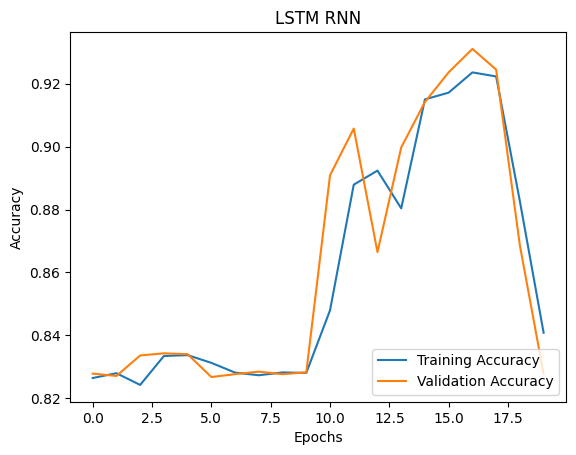

In [28]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM RNN')
plt.legend(loc='lower right')
plt.show()

## Gated Recurrent Unit (GRU)

In [29]:
class GRUModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(GRUModel, self).__init__()
        
        # Define the GRU layer
        self.gru = nn.GRU(input_size=inputSize, 
                          hidden_size=hiddenSize, 
                          num_layers=numLayers, 
                          batch_first=True
                          )
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hiddenSize, numClasses)
    
    def forward(self, x):
        # Initialize hidden state for GRU
        h0 = torch.zeros(self.gru.num_layers * (2 if self.gru.bidirectional else 1), x.size(0), self.gru.hidden_size).to(x.device)
        
        # Forward propagate through GRU
        out, _ = self.gru(x, h0)
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [30]:
# Instantiate model
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learningRate)

In [31]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(gru_model, gru_optimizer, train_loader, val_loader)

Epoch [1/20], Train Loss: 0.4953, Train Accuracy: 86.14%, Test Loss: 0.3328, Test Accuracy: 90.67%
Epoch [2/20], Train Loss: 0.2722, Train Accuracy: 92.46%, Test Loss: 0.2375, Test Accuracy: 93.37%
Epoch [3/20], Train Loss: 0.2123, Train Accuracy: 94.14%, Test Loss: 0.1990, Test Accuracy: 94.48%
Epoch [4/20], Train Loss: 0.1818, Train Accuracy: 94.96%, Test Loss: 0.1823, Test Accuracy: 94.93%
Epoch [5/20], Train Loss: 0.1581, Train Accuracy: 95.69%, Test Loss: 0.1588, Test Accuracy: 95.69%
Epoch [6/20], Train Loss: 0.1430, Train Accuracy: 95.99%, Test Loss: 0.1402, Test Accuracy: 96.11%
Epoch [7/20], Train Loss: 0.1280, Train Accuracy: 96.45%, Test Loss: 0.1319, Test Accuracy: 96.43%
Epoch [8/20], Train Loss: 0.1181, Train Accuracy: 96.82%, Test Loss: 0.1289, Test Accuracy: 96.49%
Epoch [9/20], Train Loss: 0.1123, Train Accuracy: 96.87%, Test Loss: 0.1121, Test Accuracy: 97.09%
Epoch [10/20], Train Loss: 0.1074, Train Accuracy: 97.05%, Test Loss: 0.1241, Test Accuracy: 96.62%
Epoch [11

In [32]:
# Save trained model
PATH = "./model/gru_rnn_model.pth"
torch.save(gru_model.state_dict(), PATH)

In [33]:
# Load model
PATH = "./model/gru_rnn_model.pth"
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

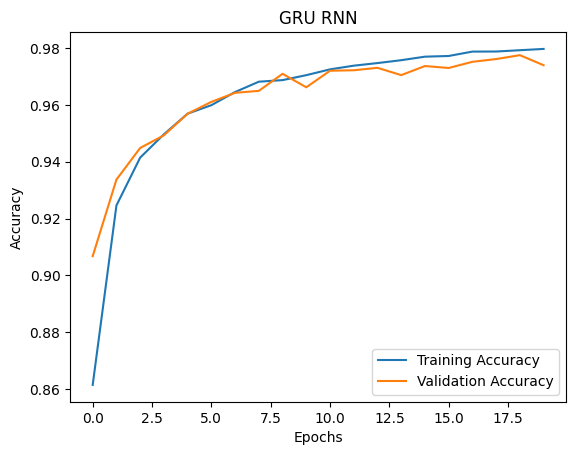

In [34]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GRU RNN')
plt.legend(loc='lower right')
plt.show()

## Testing best model on entire dataset

In [35]:
# Instantiate model
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learningRate)

train_loader, test_loader = get_dataloaders(X_train, X_test_scaled, y_train, y_test)
train_losses, train_accuracies, test_losses, test_accuracies = train_val(gru_model, gru_optimizer, train_loader, test_loader)

Epoch [1/20], Train Loss: 0.4869, Train Accuracy: 86.19%, Test Loss: 0.3878, Test Accuracy: 88.99%
Epoch [2/20], Train Loss: 0.2671, Train Accuracy: 93.15%, Test Loss: 0.2373, Test Accuracy: 94.27%
Epoch [3/20], Train Loss: 0.2195, Train Accuracy: 94.32%, Test Loss: 0.2125, Test Accuracy: 94.35%
Epoch [4/20], Train Loss: 0.1777, Train Accuracy: 95.30%, Test Loss: 0.1642, Test Accuracy: 95.55%
Epoch [5/20], Train Loss: 0.1529, Train Accuracy: 95.84%, Test Loss: 0.1398, Test Accuracy: 96.31%
Epoch [6/20], Train Loss: 0.1340, Train Accuracy: 96.31%, Test Loss: 0.1463, Test Accuracy: 96.00%
Epoch [7/20], Train Loss: 0.1206, Train Accuracy: 96.67%, Test Loss: 0.1188, Test Accuracy: 96.77%
Epoch [8/20], Train Loss: 0.1103, Train Accuracy: 96.98%, Test Loss: 0.1225, Test Accuracy: 96.56%
Epoch [9/20], Train Loss: 0.1041, Train Accuracy: 97.14%, Test Loss: 0.1079, Test Accuracy: 97.06%
Epoch [10/20], Train Loss: 0.0987, Train Accuracy: 97.30%, Test Loss: 0.0995, Test Accuracy: 97.39%
Epoch [11

In [36]:
# Save trained model
PATH = "./model/best_rnn_model.pth"
torch.save(gru_model.state_dict(), PATH)

In [37]:
# Load model
PATH = "./model/best_rnn_model.pth"
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

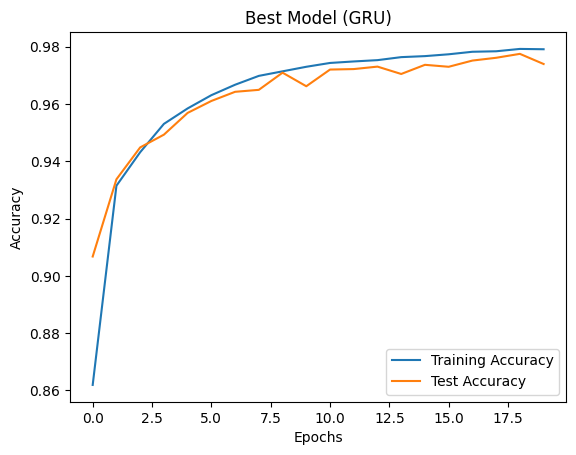

In [38]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Best Model (GRU)')
plt.legend(loc='lower right')
plt.show()